In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
import gensim
from gensim.models import Word2Vec

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,Flatten,SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

In [ ]:
# read the csv file
df = pd.read_csv("Reviews.csv")
df.head()

In [23]:
# we need only the text and score you will not always get a summary for the 
# review so i preferred to train on the whole review
df = df.loc[:,("Text",'Score')]
# remove all repeated reviews
df.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True)
df.shape

# changing names
df['review'] = df['Text']
df['rate'] = df['Score']
df.drop(['Text',"Score"],axis=1,inplace=True)
df.head()

,review,rate
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [24]:
# dividing the rating to good above 3 and bad below 3
def mark_sent(rate):
    if rate > 3:
        return 1
    else:
        return 0

df['sentiment'] = df['rate'].apply(mark_sent)
df.drop(['rate'],inplace=True,axis=1)
df.head()

,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [25]:
# printing number of reviews for each class
df["sentiment"].value_counts()

1    306819
0     86856
Name: sentiment, dtype: int64

In [26]:
# Balancing the data 
# i didn't balance the data because i found the accuracy better and there is no enough data
good_df =df.loc[df.sentiment == 1,:][:]
bad_df = df.loc[df.sentiment == 0,:][:]

df = pd.concat([good_df,bad_df],ignore_index=True)
print(df.shape)
df.head()

(393675, 2)


,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,This is a confection that has been around a fe...,1
2,Great taffy at a great price. There was a wid...,1
3,I got a wild hair for taffy and ordered this f...,1
4,This saltwater taffy had great flavors and was...,1


In [27]:
# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(393675, 2)


,review,sentiment
0,A chocolate this dark is an acquired taste... ...,1
1,"I wasn't expecting much from a calorie-free ""c...",0
2,First time green tea drinker and prefer it to ...,1
3,Is there really a better bar than this one? N...,1
4,As long as you use correct water temp. this ne...,1


In [28]:
data_df = df

reviews = data_df.iloc[:,0].values
y_data = data_df.iloc[:,1].values
trainset = reviews

In [29]:
# putting every review in token
tokens = []
tokens = [word_tokenize(str(sent)) for sent in reviews]

# replacing all non characters by space then splitting the sentences into words
words = []
for sent in tokens:
    s = re.sub("[^A-Za-z]"," ",str(sent))
    word = re.split("\s",s)
    words.append(word)

# removing all spaces from words list    
for word in words:
    while '' in word:
        word.remove('')
        
lower_case = []
for i in words:
    x = [word.lower() for word in i]
    lower_case.append(x)

# taking the root of every word
lemmatized = []
for words in lower_case:
    x = [WordNetLemmatizer().lemmatize(word) for word in words]
    lemmatized.append(x)

In [30]:
# removing all stopwords
# I didn't remove the stop words because people sometimes say about something which is bad "not good" for example 
# so "not" here is a stop word if i did remove it the review will be "good" 
stopwords = set(stopwords.words('english'))
filterd_words = []
for words in lemmatized:
    x = [word for word in words] #if word not in stopwords]   
    filterd_words.append(x)                                               

In [31]:
# taking words that are bigger than 2    
filterd = []
for words in filterd_words:
    x = [word for word in words if len(word) >= 2]
    filterd.append(x)

# converting words into vectors
model_word2vec = Word2Vec(filterd)
model_word2vec.train(filterd,epochs=10,total_examples=len(filterd))
words_vector = model_word2vec.wv
vocab = words_vector.vocab.items()

embedd_matrix = words_vector.vectors
word2id = {key:value.index for key,value in vocab}

# unknown words
UNKs = 0
UNK_index = 0
UNK_token = 'UNK'
UNK_vector = np.mean(embedd_matrix,axis=0)

embedd_matrix = np.insert(embedd_matrix,[UNK_index],[UNK_vector],axis=0)
word2id = {word:(index+1) if index >= UNK_index else index for word,index in word2id.items()}
word2id[UNK_token] = UNK_index

sequences = []
for sent in filterd:
    x = []
    for word in sent:
        if word in word2id:
            x.append(word2id.get(word))
        else:
            x.append(UNK_index)
            UNKs+=1
    sequences.append(x)    

In [32]:
# padding each review to be consistent
data = pad_sequences(sequences,maxlen=300,padding='post',dtype='float')

In [33]:
# one hot encoded
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y_data)

In [34]:
# another way to prepare the data 
train_temp = []
for sentence in trainset:
    train_temp.append(text_to_word_sequence(str(sentence),filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                            lower=True,split=" "))
filtered_temp = []
for sentence in train_temp:
    w = [word for word in sentence]
    filtered_temp.append(w)

x = []
for sentence in filtered_temp:
    z = []
    for word in sentence:
        if word in word2id and len(word) > 2:
            z.append(word2id.get(word))
        else:
            z.append(UNK_index)
            UNKs+=1
    x.append(z)
temp_data = pad_sequences(x,maxlen=300,padding='post',dtype='float')

In [35]:
# learning rate decay
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]

In [37]:
# spliting the data into train and validation
x_train,x_val,y_train,y_val = train_test_split(data,y_data,test_size=0.1,random_state=42,shuffle=True)

input_dims = len(embedd_matrix)

model = Sequential()
model.add(Embedding(input_dim=input_dims,output_dim=100,input_length=300,weights=[embedd_matrix]))
model.add(LSTM(80,activation='tanh',return_sequences=True))
model.add(LSTM(64,activation='tanh',return_sequences=True))
model.add(Flatten())
model.add(Dense(16,activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(8,activation='tanh'))
# model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

from tensorflow.keras.optimizers import Adam,RMSprop
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          3154900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 80)           57920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 64)           37120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                307216    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 3,557,173
Trainable params: 3,557,173
Non-trainable params: 0
____________________________________________

In [38]:
# reducing the learning rate over plateau
from tensorflow.keras.callbacks import *
reduce_lr = ReduceLROnPlateau(montor='val_loss',patience=2,mode='auto',verbose=1,factor=0.5)

In [39]:
# training the model
start = time.time()
batch_size = 32
epochs = 10
trained_model = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,shuffle=True,
                          validation_data=(x_val,y_val),callbacks=[reduce_lr])
end = time.time() - start
print("Totla Time: {:.3f}min".format(end/60))

Train on 354307 samples, validate on 39368 samples
Epoch 1/10
354307/354307 [==============================] - 714s 2ms/sample - loss: 0.2336 - accuracy: 0.9030 - val_loss: 0.2017 - val_accuracy: 0.9181
Epoch 2/10
354307/354307 [==============================] - 653s 2ms/sample - loss: 0.1884 - accuracy: 0.9247 - val_loss: 0.1903 - val_accuracy: 0.9215
Epoch 3/10
354307/354307 [==============================] - 649s 2ms/sample - loss: 0.1670 - accuracy: 0.9341 - val_loss: 0.1853 - val_accuracy: 0.9270
Epoch 4/10
354307/354307 [==============================] - 650s 2ms/sample - loss: 0.1490 - accuracy: 0.9419 - val_loss: 0.1923 - val_accuracy: 0.9235
Epoch 5/10
354304/354307 [============================>.] - ETA: 0s - loss: 0.1306 - accuracy: 0.9503
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
354307/354307 [==============================] - 654s 2ms/sample - loss: 0.1306 - accuracy: 0.9503 - val_loss: 0.1990 - val_accuracy: 0.9230
Epoch 6/10
354307/

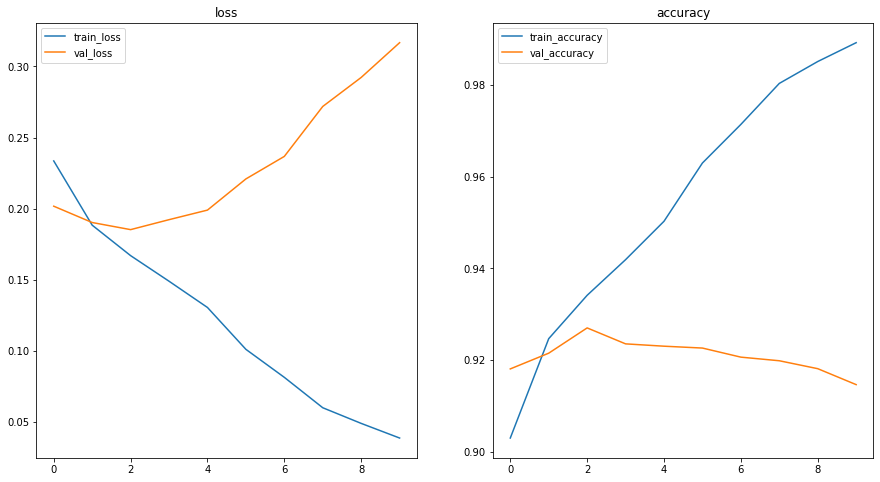

In [40]:
# ploting the loss and accuarcy for the training and validation phase
train_acc = trained_model.history['accuracy']
train_loss = trained_model.history['loss']
val_acc = trained_model.history['val_accuracy']
val_loss = trained_model.history['val_loss']

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),train_loss,label='train_loss')
plt.plot(range(epochs),val_loss,label='val_loss')
plt.title('loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(epochs),train_acc,label='train_accuracy')
plt.plot(range(epochs),val_acc,label='val_accuracy')
plt.title('accuracy')
plt.legend()